In [109]:
import graph_tool.all as gt
from math import sqrt

In [110]:
from random import *

In [111]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [112]:
import igraph as ig

In [113]:
F=ig.Graph.Read("../graphs/ncol/facebook_combined.txt",format="ncol").as_undirected()

In [114]:
print([v for v in F.vs])

[igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 0, {'name': 'V0'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 1, {'name': 'V1'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 2, {'name': 'V2'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 3, {'name': 'V3'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 4, {'name': 'V4'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 5, {'name': 'V5'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 6, {'name': 'V6'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 7, {'name': 'V7'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 8, {'name': 'V8'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 9, {'name': 'V9'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 10, {'name': 'V10'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 11, {'name': 'V11'}), igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 12, {'name': 'V12'}), igraph.Vertex(<igr

In [115]:
def findCommunities(graph):
    partition=graph.community_multilevel()
    for idx, c in enumerate(partition):
        color=[random(),random(),random(),1.]
        for v in c:
            partition.graph.vs[v]["color"]=color
            partition.graph.vs[v]["cluster"]=idx
            for e in partition.graph.incident(v):
                ed=partition.graph.es[e]
                if ed.source in c and ed.target in c:
                    ed["color"]=[0.,0.,0.,1.]
                else:
                    ed["color"]=[0.5,0.5,0.5,1.]
    return partition

In [116]:
#print(partition)

In [117]:
def chooseVertex(graph):
    assert len(graph.vs)>0, "Can't choose a vertex in an empty graph." 
    node=None
    minBetweenness = -1
    for idx, betweenness in enumerate(graph.betweenness()):
        if betweenness < minBetweenness or minBetweenness == -1 :
            node= idx
    assert node is not None
    return node

In [118]:
def maxMinPCCNodeSelection(dictPCC):
    assert dictPCC!={}
    chosenId=None
    nbNodes=len(list(dictPCC.values())[0])
    maxDist=-1
    maxDistNode=None
    for nodeId in range(nbNodes):
        if nodeId not in dictPCC.keys():
            minDist=-1
            minDistNode=nodeId
            for chosenNode in dictPCC.keys():
                if minDist==-1 or dictPCC[chosenNode][nodeId]<minDist:
                    minDist=dictPCC[chosenNode][nodeId]
            if minDist>maxDist:
                maxDist=minDist
                maxDistNode=minDistNode
    chosenId=maxDistNode
    return chosenId

In [119]:
def maxShortestPathNodesSelection(graph,nbNodes,boundaryNodes=[]):
    if boundaryNodes==[]:
        chosenIds=[chooseVertex(graph)]
    else:
        chosenIds=boundaryNodes.copy()
    #BFS initial des noeuds dans chosenIds
    matPCC=graph.shortest_paths_dijkstra(chosenIds)
    dictPCC={chosenId:matPCC[idxPCC] for idxPCC,chosenId in enumerate(chosenIds)}
    #print("d",dictPCC)
    #nbNodes fois
    #print("l",len(chosenIds),nbNodes)
    while len(chosenIds)-len(boundaryNodes)<nbNodes:
        #print(".")
        chosenNodeId=maxMinPCCNodeSelection(dictPCC)
        #print("ci",chosenNodeId)
        #BFS du nouveau noeud
        dictPCC[chosenNodeId]=graph.shortest_paths_dijkstra(chosenNodeId)[0] #On prend la ligne de la matrice qui correspond au noeud
        chosenIds.append(chosenNodeId)
    assert len(chosenIds)==len(boundaryNodes)+nbNodes
    return chosenIds[len(boundaryNodes):]

In [120]:
def assignWorkers(graph,nWorkers):
    assert nWorkers>=0, "{} workers to assign: Number of workers to assign must be positive or zero".format(nWorkers)
    assert len(graph.vs)>=nWorkers, "{} workers to assign on {} nodes: Can't assign more workers than there are vertices".format(nWorkers,len(graph.vs))
    partition=findCommunities(graph)
    
    clusterGraph=partition.cluster_graph("first")

    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["name"]="C{}".format(idx)
    #print(clusterGraph)
    workerIds=[]
    chosenClusters=[]
    if len(partition)<nWorkers:
        pass #Etape 1'
    #PC:il y a au moins autant de clusters que de workers
    if len(partition)==nWorkers:
        #1cluster/1worker
        for cluster in clusterGraph.vs:
            cluster["nb_workers"]=1
    else:
        clusterIds=maxShortestPathNodesSelection(clusterGraph,nWorkers)
        for cluster in clusterGraph.vs:
            if cluster.index in clusterIds:
                cluster["nb_workers"]=1
            else:
                cluster["nb_workers"]=0
    #workerIds=clusterIds
    #print(clusterIds)
    #Etape2
    #for chaque cluster de workers
    for clusterId in clusterIds:
        clusterVertices=[v for v in graph.vs if v["cluster"]==clusterId]
        boundaryVertices=set()
        for v in clusterVertices:
            boundaryVertices.update([bv for bv in v.successors() if bv["cluster"]!=clusterId])
        boundaryVertices=list(boundaryVertices)
        boundedCluster=graph.induced_subgraph(boundaryVertices+clusterVertices)
        boundaryVerticesNames=[v["name"] for v in boundaryVertices]
        boundaryVertices=[v.index for v in boundedCluster.vs if v["name"] in boundaryVerticesNames]
        #print(boundaryVertices)
        #print(clusterGraph.vs[clusterId]["nb_workers"])
        workerId=maxShortestPathNodesSelection(boundedCluster,clusterGraph.vs[clusterId]["nb_workers"],boundaryVertices)
        workerIds.extend(boundedCluster.vs[workerId]["name"])
    #prendre son sous-graphe+ les noeuds frontaliers d'autres clusters, BFS des frontières et Etape1 nb_workers fois
    #print([v["nb_workers"] for v in clusterGraph.vs])
    assert len(workerIds)==nWorkers
    return workerIds,partition,clusterIds,boundedCluster

In [125]:
workerIds,partition,clusterIds,boundedCluster=assignWorkers(F,10)
print(workerIds)
for node in boundedCluster.vs:
    if node["name"]in workerIds:
        node["shape"]="triangle"
clusterGraph=partition.cluster_graph()
ig.plot(boundedCluster)

['V1924', 'V389', 'V2670', 'V1', 'V1951', 'V576', 'V3981', 'V687', 'V427', 'V899']


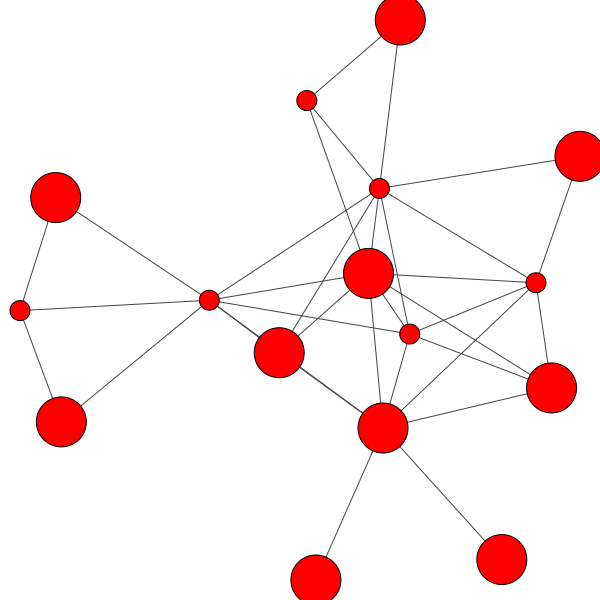

In [126]:
for cluster in clusterGraph.vs:
    if cluster.index in clusterIds:
        cluster["size"]=50
ig.plot(clusterGraph)

In [127]:
for v in F.vs:
    if v["name"] in workerIds:
        print(v)
        v["size"]=25
        v["shape"]="triangle"
    else:
        v["size"]=1
        v["shape"]="circle"

igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 1, {'name': 'V1', 'color': [0.23207428510940442, 0.3135309531566408, 0.13664977468005102, 1.0], 'cluster': 0, 'size': 1, 'shape': 'circle'})
igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 363, {'name': 'V389', 'color': [0.5220274328901685, 0.232605814629948, 0.24861831256255706, 1.0], 'cluster': 5, 'size': 25, 'shape': 'triangle'})
igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 385, {'name': 'V899', 'color': [0.27035661157775326, 0.9229796311005429, 0.08507277066188379, 1.0], 'cluster': 2, 'size': 1, 'shape': 'circle'})
igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 1401, {'name': 'V1951', 'color': [0.69055764800823, 0.2973070260345464, 0.33825322703175276, 1.0], 'cluster': 8, 'size': 1, 'shape': 'circle'})
igraph.Vertex(<igraph.Graph object at 0x7eff9441b220>, 1508, {'name': 'V427', 'color': [0.0465614908086438, 0.29826236607897716, 0.34514114988153044, 1.0], 'cluster': 1, 'size': 1, 'shape': 'circle'})
igr

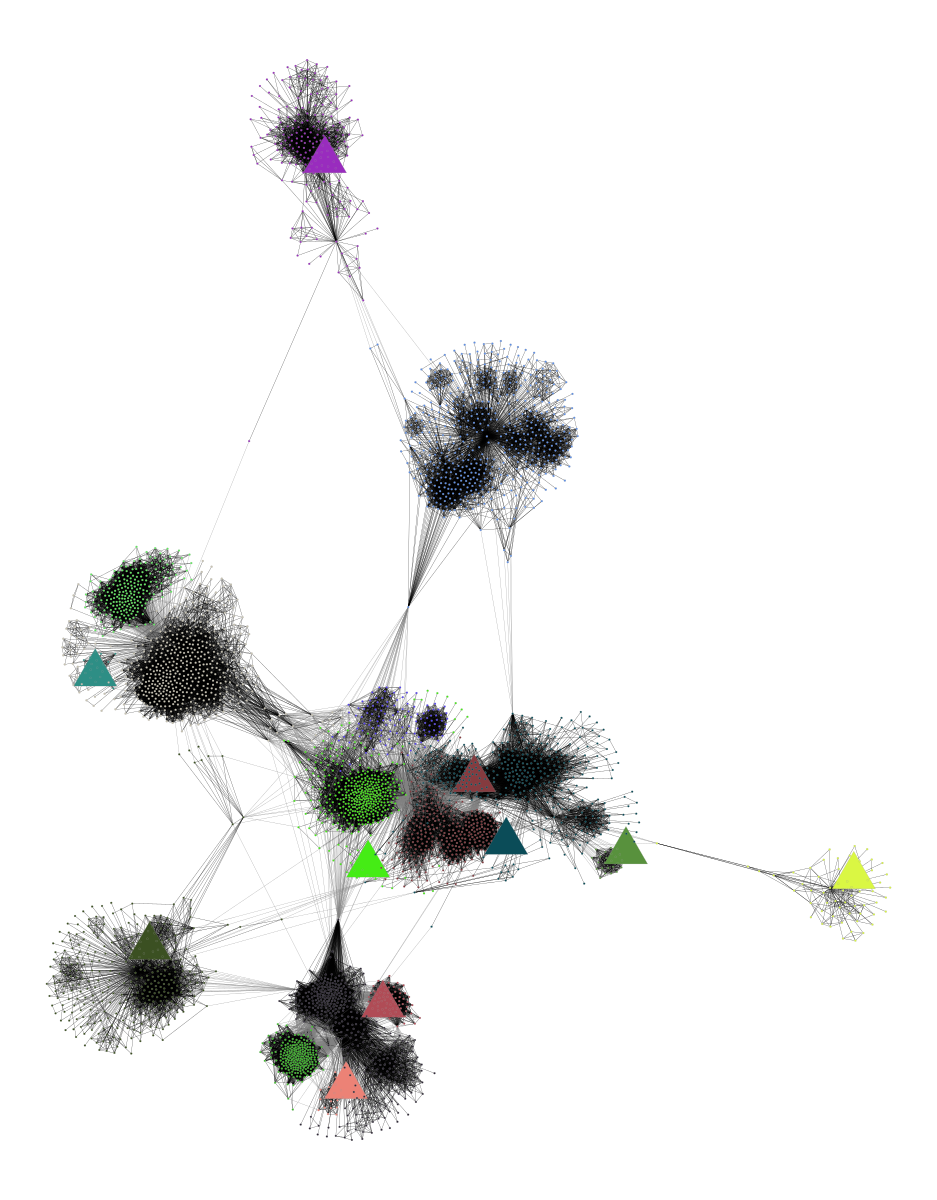

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7eff8a1c79d0, at 0x7eff94ef0640>

In [128]:
G=F.to_graph_tool(vertex_attributes={"color":"vector<float>","size":"int","shape":"string"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],vertex_shape=G.vertex_properties["shape"],vertex_size=G.vertex_properties["size"],edge_color=G.edge_properties["color"])